# PROJECT DETAILS

ViolenceXplainAR

Research and Development

Supervisor: Mr. Hassan Mustafa

# Group Members

Iqra Aziz&emsp;&emsp;&emsp;&emsp;&emsp;&ensp; 18I-0491

Tehreem Khawar   &emsp;&ensp;   18I-0489 &nbsp; 

Hafsa   &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;      18I-0405 &nbsp; 

# CODE REFERENCES

http://www.heatmapping.org/

https://git.tu-berlin.de/gmontavon/lrp-tutorial

# IMPORTS


In [32]:
import cv2
import torchvision
import torch
import urllib
from PIL import Image
from torchvision import transforms

# LOADING MODEL

In [28]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

Using cache found in /home/violencexplainar/.cache/torch/hub/pytorch_vision_v0.6.0


In [29]:
#Model description
AlexNet_model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# LAYERS

In [30]:
layers = list(AlexNet_model._modules['features']) + list(AlexNet_model._modules['classifier'])
L = len(layers)
print("Total number of Layers:", L)

Total number of Layers: 20


# Loading an Image for Heatmap Generation

In [31]:
filename = ("/home/violencexplainar/Desktop/testset_images/bucket.jpg")

# EXECUTION OF MODEL USING TORCHVISION

In [34]:

input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    AlexNet_model.to('cuda')

with torch.no_grad():
    output = AlexNet_model(input_batch)
    
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)


# DOWNLOAD IMAGENET LABELS

In [12]:
#!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

# READING THE CATEGORIES AND SHOWING TOP ONES

In [35]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
    
# Show top 5 categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())
max_prob = top5_catid[0]
print(max_prob,top5_prob[0].item())

measuring cup 0.8919405341148376
beaker 0.1034313440322876
bucket 0.003189670154824853
sunscreen 0.0005878391675651073
candle 0.00012576013978105038
tensor(647, device='cuda:0') 0.8919405341148376


# FORWARD PASS

In [53]:
X = input_batch
print("Size of Input Image", X.shape)

Size of Input Image torch.Size([1, 3, 224, 224])


# ACTIVATIONS

In [61]:
A = [X] + [None] * L
print("Number of Activations: ",len(A))
print("Activation 0 (Image) Shape", A[0].shape) #image activation

#total activations : 21
#total layers : 20
for l in range(14): #activations for first sequential i.e., features (conv2d and MaxPool2d)
    A[l+1] = layers[l].forward(A[l])
    print("Activation ",l+1, " Shape:", A[l+1].shape) 


Number of Activations:  21
Activation 0 (Image) Shape torch.Size([1, 3, 224, 224])
Activation  1  Shape: torch.Size([1, 64, 55, 55])
Activation  2  Shape: torch.Size([1, 64, 55, 55])
Activation  3  Shape: torch.Size([1, 64, 27, 27])
Activation  4  Shape: torch.Size([1, 192, 27, 27])
Activation  5  Shape: torch.Size([1, 192, 27, 27])
Activation  6  Shape: torch.Size([1, 192, 13, 13])
Activation  7  Shape: torch.Size([1, 384, 13, 13])
Activation  8  Shape: torch.Size([1, 384, 13, 13])
Activation  9  Shape: torch.Size([1, 256, 13, 13])
Activation  10  Shape: torch.Size([1, 256, 13, 13])
Activation  11  Shape: torch.Size([1, 256, 13, 13])
Activation  12  Shape: torch.Size([1, 256, 13, 13])
Activation  13  Shape: torch.Size([1, 256, 6, 6])
Activation  14  Shape: torch.Size([1, 256, 6, 6])


In [62]:
#reshaping the matrix to apply linear using avgpool2d
l=14

bs, _, _, _ = A[l].shape
A[l] = A[l].reshape(bs, -1)

In [63]:
#activations of second sequential i.e., classifier (linear) from layer 15 to 20
l = 14 
A[l+1] = layers[l].forward(A[l])
print("Layer", l+1, " Activation", A[l].shape)

l += 1 
A[l+1] = layers[l].forward(A[l])
print("Layer", l+1, " Activation", A[l].shape)

l += 1
A[l+1] = layers[l].forward(A[l])
print("Layer", l+1, " Activation", A[l].shape)

l += 1
A[l+1] = layers[l].forward(A[l])
print("Layer", l+1, " Activation", A[l].shape)

l += 1
A[l+1] = layers[l].forward(A[l])
print("Layer", l+1, " Activation", A[l].shape)

l += 1
A[l+1] = layers[l].forward(A[l])
print("Layer", l+1, " Activation", A[l].shape)


Layer 15  Activation torch.Size([1, 9216])
Layer 16  Activation torch.Size([1, 4096])
Layer 17  Activation torch.Size([1, 4096])
Layer 18  Activation torch.Size([1, 4096])
Layer 19  Activation torch.Size([1, 4096])
Layer 20  Activation torch.Size([1, 4096])


# Probabilities of classes

In [64]:
import numpy
import utils2
scores = numpy.array(A[-1].data.view(-1).cpu())
ind = numpy.argsort(-scores)
for i in ind[:10]:
    print('%20s (%3d): %6.3f'%(utils2.imgclasses[i][:20],i,scores[i]))

       measuring cup (647): 22.674
              beaker (438): 20.519
        bucket, pail (463): 17.040
sunscreen, sunblock, (838): 15.349
candle, taper, wax l (470): 13.807
           water jug (899): 13.720
              lotion (631): 13.544
              nipple (680): 13.528
              goblet (572): 13.348
    perfume, essence (711): 12.618


# Choosing Max Probabilities

In [65]:
T = torch.FloatTensor((1.0*(numpy.arange(1000)==647).reshape([1,1000,1,1])))

# Calculating Relevances

In [75]:
R = [None]*L + [(A[-1].cuda()*T.cuda()).data]

In [76]:
#for classifier sequential
for l in range(13,20)[::-1]:
    
    A[l] = (A[l].data).requires_grad_(True)

    if isinstance(layers[l],torch.nn.MaxPool2d): layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d) or isinstance(layers[l],torch.nn.Linear):

        if l <= 7:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
        if 8 <= l <= 12: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        if l >= 13:       rho = lambda p: p;                       incr = lambda z: z+1e-9

        z = incr(utils2.newlayer(layers[l],rho).forward(A[l]))  # step 1
        s = (R[l+1]/z).data                                    # step 2
        (z*s).sum().backward(); c = A[l].grad                  # step 3
        R[l] = (A[l]*c).data   # step 4
        print("Relevance ", l, " Shape:",R[l].shape)
        
    else:
        # On Activation and dropout layers Relevance is simply passed back 
        layers[l]
        R[l] = R[l+1]


Relevance  19  Shape: torch.Size([1, 4096])
Relevance  17  Shape: torch.Size([1, 4096])
Relevance  14  Shape: torch.Size([1, 9216])


In [77]:
#dimension matching between sequentials
import numpy as np
l = 12
A[l] = (A[l].data).requires_grad_(True)

if isinstance(layers[l],torch.nn.MaxPool2d): layers[l] = torch.nn.AvgPool2d(2)

if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d) or isinstance(layers[l],torch.nn.Linear):

    if l <= 7:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
    if 8 <= l <= 12: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
    if l >= 13:       rho = lambda p: p;                       incr = lambda z: z+1e-9

    z = incr(utils2.newlayer(layers[l],rho).forward(A[l]))  # step 1
    print ("R13 before reshaping: ",R[l+1].shape)

    R[l+1] = R[l+1].reshape(1,256,6,6)



    print ("R13 after reshaping: ",R[l+1].shape)

    s = (R[l+1].cuda()/z.cuda()).data                                    # step 2
    (z*s).sum().backward(); c = A[l].grad                  # step 3
    R[l] = (A[l]*c).data

R13 before reshaping:  torch.Size([1, 9216])
R13 after reshaping:  torch.Size([1, 256, 6, 6])


In [79]:
#for features sequential
for l in range(1,12)[::-1]:
    
    A[l] = (A[l].data).requires_grad_(True)

    if isinstance(layers[l],torch.nn.MaxPool2d): layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d) or isinstance(layers[l],torch.nn.Linear):

        if l <= 7:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
        if 8 <= l <= 12: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        if l >= 13:       rho = lambda p: p;                       incr = lambda z: z+1e-9

        z = incr(utils2.newlayer(layers[l],rho).forward(A[l]))  # step 1
        s = (R[l+1]/z).data                                    # step 2
        (z*s).sum().backward(); c = A[l].grad                  # step 3
        R[l] = (A[l]*c).data   # step 4
        print("Relevance ", l, " Shape:",R[l].shape)
    else:
        layers[l]
        R[l] = R[l+1]

Relevance  10  Shape: torch.Size([1, 256, 13, 13])
Relevance  8  Shape: torch.Size([1, 384, 13, 13])
Relevance  6  Shape: torch.Size([1, 192, 13, 13])
Relevance  5  Shape: torch.Size([1, 192, 27, 27])
Relevance  3  Shape: torch.Size([1, 64, 27, 27])
Relevance  2  Shape: torch.Size([1, 64, 55, 55])


# Top Most Layer (L=0) (1,3,224,224)

In [81]:
l=0
A[0] = (A[0].data).requires_grad_(True)
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1, -1, 1, 1)
std = torch.Tensor([0.229, 0.224, 0.225]).reshape(1, -1, 1, 1)
x=(0-mean)/std
y=A[0].data*0
z=(1-mean)/std
lb = (y.cuda()+x.cuda()).requires_grad_(True)
hb = (y.cuda()+z.cuda()).requires_grad_(True)

z = layers[0].forward(A[0]) + 1e-9                                     # step 1 (a)
z -= utils2.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
z -= utils2.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
s = (R[1]/z).data                                                      # step 2
(z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad            # step 3
R[0] = (A[0]*c+lb*cp+hb*cm).data 

print("Relevance ", l, " Shape:",R[l].shape)

Relevance  0  Shape: torch.Size([1, 3, 224, 224])


# HeatMaps

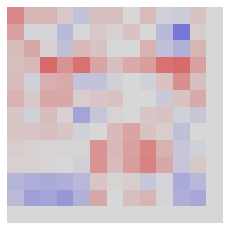

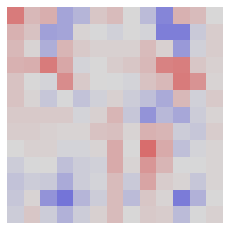

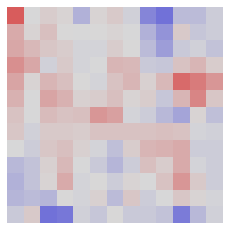

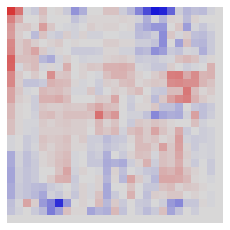

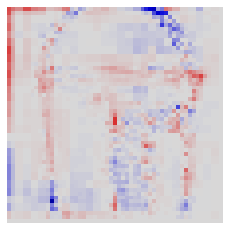

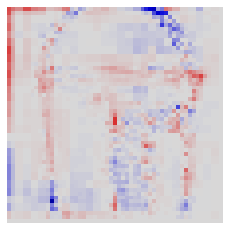

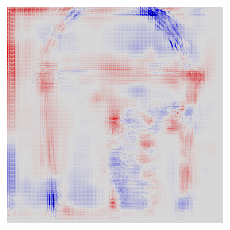

In [82]:
utils2.heatmap(R[11][0].sum(axis=0).cpu().detach().numpy(),3,3)
utils2.heatmap(R[9][0].sum(axis=0).cpu().detach().numpy(),3,3)
utils2.heatmap(R[6][0].sum(axis=0).cpu().detach().numpy(),3,3)
utils2.heatmap(R[4][0].sum(axis=0).cpu().detach().numpy(),3,3)
utils2.heatmap(R[2][0].sum(axis=0).cpu().detach().numpy(),3,3)
utils2.heatmap(R[1][0].sum(axis=0).cpu().detach().numpy(),3,3)
utils2.heatmap(numpy.array(R[0][0].cpu()).sum(axis=0),3,3)